# Projet FISA : Classification de fruits

 Un grand nombre de fruits sont cultivés dans le monde entier, chacun d'entre eux présentant différents types. Les facteurs qui déterminent le type de fruit sont les caractéristiques de l'aspect extérieur telles que la couleur, la longueur, le diamètre et la forme. L'aspect extérieur des fruits est un facteur déterminant du type de fruit. Déterminer la variété de fruits en fonction de leur aspect extérieur peut nécessiter une expertise, ce qui prend du temps et demande beaucoup d'efforts.

**Objectif :**  classer les types de fruits de la datte, à savoir *Barhee, Deglet Nour, Sukkary, Rotab Mozafati, Ruthana, Safawi et Sagai*, en utilisant plusieurs méthodes de classification.

 À cette fin, **898 images** de sept types différents de fruits de la datte ont été obtenues via le système de vision par ordinateur (CVS). Grâce à des techniques de traitement d'images, un total de **34 caractéristiques**, dont les caractéristiques morphologiques, la forme et la couleur, ont été extraites de ces images.



Auteurs : Ruddy KINSICLOUNON - Galatée MARCQ 2A SN FISA

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
import scipy
import sklearn
import math
from sklearn.mixture import GaussianMixture
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.cluster import KMeans, SpectralClustering, AgglomerativeClustering
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn import preprocessing
from mpl_toolkits import mplot3d

## Chargement des données

In [2]:
# Chargement des données
DataSet = pd.read_excel('./Date_Fruit_Datasets.xlsx')
Classes = DataSet.pop("Class")

Data=np.array(DataSet)
DataSet.head()

,AREA,PERIMETER,MAJOR_AXIS,MINOR_AXIS,ECCENTRICITY,EQDIASQ,SOLIDITY,CONVEX_AREA,EXTENT,ASPECT_RATIO,...,SkewRB,KurtosisRR,KurtosisRG,KurtosisRB,EntropyRR,EntropyRG,EntropyRB,ALLdaub4RR,ALLdaub4RG,ALLdaub4RB
0,422163,2378.908,837.8484,645.6693,0.6373,733.1539,0.9947,424428,0.7831,1.2976,...,0.6019,3.2370,2.9574,4.2287,-59191263232,-50714214400,-39922372608,58.7255,54.9554,47.8400
1,338136,2085.144,723.8198,595.2073,0.5690,656.1464,0.9974,339014,0.7795,1.2161,...,0.4134,2.6228,2.6350,3.1704,-34233065472,-37462601728,-31477794816,50.0259,52.8168,47.8315
2,526843,2647.394,940.7379,715.3638,0.6494,819.0222,0.9962,528876,0.7657,1.3150,...,0.9183,3.7516,3.8611,4.7192,-93948354560,-74738221056,-60311207936,65.4772,59.2860,51.9378
3,416063,2351.210,827.9804,645.2988,0.6266,727.8378,0.9948,418255,0.7759,1.2831,...,1.8028,5.0401,8.6136,8.2618,-32074307584,-32060925952,-29575010304,43.3900,44.1259,41.1882
4,347562,2160.354,763.9877,582.8359,0.6465,665.2291,0.9908,350797,0.7569,1.3108,...,0.8865,2.7016,2.9761,4.4146,-39980974080,-35980042240,-25593278464,52.7743,50.9080,42.6666


In [3]:
# Encodage du label en fonction des espèces de dattes
label= LabelEncoder()
integer_labels = label.fit_transform(Classes)
print(np.unique(integer_labels), np.unique(Classes))

[0 1 2 3 4 5 6] ['BERHI' 'DEGLET' 'DOKOL' 'IRAQI' 'ROTANA' 'SAFAVI' 'SOGAY']


###  Découpage de l'ensemble de données en Apprentissage et test pour les approches supevisée.

In [4]:
from sklearn import preprocessing
# Séparation de l'ensemble de données en Base d'apprentissage et base de test
from sklearn.model_selection import train_test_split

min_max_scaler = preprocessing.MinMaxScaler().fit(Data)
scaled_data = min_max_scaler.transform(Data)

# K-folding divide in 5 parts and try 80% training into 20% testing 5 times
X_train, X_test, y_train, y_test = train_test_split(Data, integer_labels, random_state=0,test_size=0.2)
X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(scaled_data, integer_labels, random_state=0,test_size=0.2)

print('Dimension Base d apprentissage :', X_train.shape)
print('Dimension Base de test :', X_test.shape)

Dimension Base d apprentissage : (718, 34)
Dimension Base de test : (180, 34)


### Fonctions pour réaliser une table de correspondance entre le label des approches non supervisées et le label réel

In [5]:
def retrieve_info(cluster_labels,y_train):
 #Associe l'étiquette la plus probable à chaque groupe dans le modèle KMeans.
 #Résultats : dictionnaire des clusters associés à chaque étiquette.

# Initialisation
  reference_labels = np.zeros((len(np.unique(cluster_labels)),1))
# Loop pour chaque label
  for i in range(len(np.unique(cluster_labels))):
    index = np.where(cluster_labels == i,1,0)
    num = np.bincount(y_train[index==1]).argmax()
    reference_labels[i] = num
  return reference_labels

def correspondance(y_pred,label):
  # Correspondance entre la partition du clusterin y_pred et les classes de la vérité terrain label
  reference_labels = retrieve_info(y_pred,label)
  number_labels = np.zeros(len(y_pred))
  for i in range(len(y_pred)):
    number_labels[i] = reference_labels[y_pred[i]]
  return number_labels


# Partie I : Classification des phonèmes sans prétraitement

Réaliser une classification de ces fruits par une méthode d'apprentissage supervisé et une méthode d'apprentissage non supervisé de votre choix en utilisant soit les codes des TP précédents, soit en utilisant la librairie *scikit-learn*.

Pour chaque résultat obtenu, calculer la matrice de confusion et interpréter les résultats.

## Méthode supervisée  :
indiquer quelle est la méthode superviée de votre choix et calculer la matrice de confusion associée.

**1) Bayes**

In [6]:
from sklearn.naive_bayes import GaussianNB

# chargement du modèle et de ses paramètres
clf = GaussianNB()
# Apprentissage du modèle et de ses paramètres à l'aide des données étiquettées, 
# c'est-à-dire de la base d'apprentissage, X_train et de ses labels y_train
clf.fit(X_train, y_train)

# Une fois le modèle appris, on teste ce modèle sur un nouveau jeu de données X_test
y_pred = clf.predict(X_test)

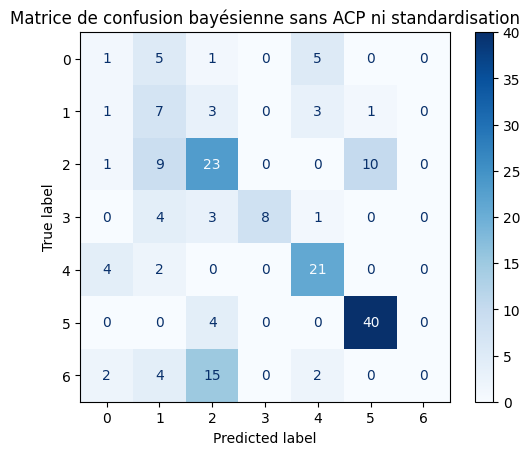

In [7]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Calcul de la matrice de confusion
#y_correspondant = correspondance(y_pred_Bayes,integer_labels)
cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
labels = np.unique(integer_labels)
display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
display.plot(cmap=plt.cm.Blues)
plt.title("Matrice de confusion bayésienne sans ACP ni standardisation")
plt.show()

In [8]:
def accuracy(conf_matrix):
    correct_prediction = conf_matrix.diagonal().sum()
    return  correct_prediction / conf_matrix.sum()

accuracy(cm)

0.5555555555555556

**Scaled**

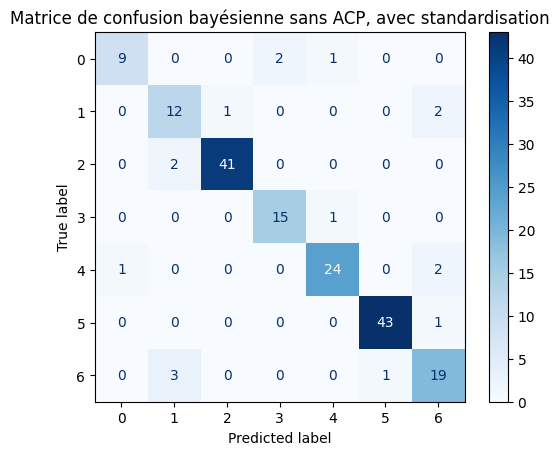

0.9055555555555556

In [9]:
clf.fit(X_train_scaled, y_train_scaled)

# Une fois le modèle appris, on teste ce modèle sur un nouveau jeu de données X_test
y_pred_Bayes = clf.predict(X_test_scaled)
cm = confusion_matrix(y_test, y_pred_Bayes, labels=clf.classes_)
labels = np.unique(integer_labels)
display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
display.plot(cmap=plt.cm.Blues)
plt.title("Matrice de confusion bayésienne sans ACP, avec standardisation")
plt.show()
accuracy(cm)

**[2) Nearest Neighbors](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier) :**

In [10]:
from sklearn.neighbors import KNeighborsClassifier
_accuracy = []
for k in range(1, len(X_train)):
    neigh = KNeighborsClassifier(n_neighbors=k)
    neigh.fit(X_train, y_train)
    y_pred_neigh = neigh.predict(X_test)
    _accuracy.append(np.sum(np.diagonal(confusion_matrix(y_test, y_pred_neigh))))

In [11]:
best_n_neighbors = np.argmax(np.array(_accuracy))

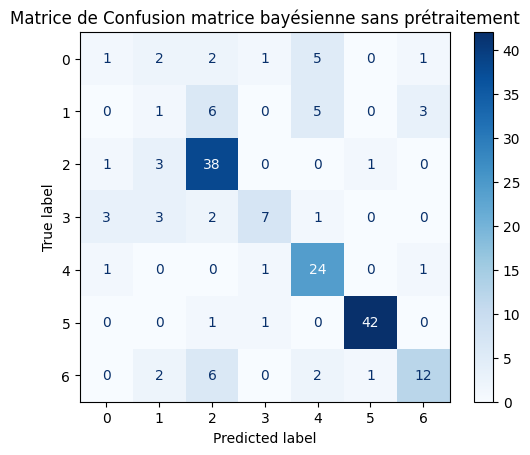

0.6944444444444444

In [12]:
neigh = KNeighborsClassifier(n_neighbors=best_n_neighbors+1)
neigh.fit(X_train, y_train)
y_pred = neigh.predict(X_test)
cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
labels = np.unique(integer_labels)
display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
display.plot(cmap=plt.cm.Blues)
plt.title("Matrice de Confusion matrice bayésienne sans prétraitement")
plt.show()
accuracy(cm)

**Scaled**

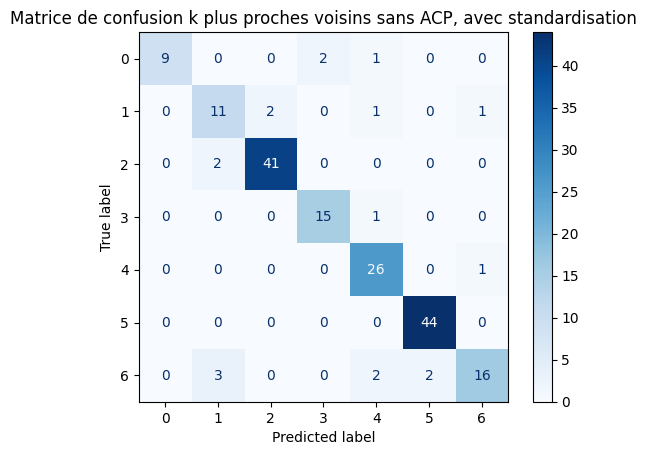

In [13]:
_accuracy = []
for k in range(1, len(X_train_scaled)):
    neigh = KNeighborsClassifier(n_neighbors=k)
    neigh.fit(X_train_scaled, y_train_scaled)
    y_pred_neigh = neigh.predict(X_test_scaled)
    _accuracy.append(np.sum(np.diagonal(confusion_matrix(y_test, y_pred_neigh))))
best_n_neighbors = np.argmax(np.array(_accuracy))
neigh = KNeighborsClassifier(n_neighbors=best_n_neighbors + 1)
neigh.fit(X_train_scaled, y_train_scaled)
y_pred_neigh = neigh.predict(X_test_scaled)
cm = confusion_matrix(y_test_scaled, y_pred_neigh, labels=clf.classes_)
labels = np.unique(integer_labels)
display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
display.plot(cmap=plt.cm.Blues)
plt.title("Matrice de confusion k plus proches voisins sans ACP, avec standardisation")
plt.show()

In [14]:
accuracy(cm)

0.9

## Méthode non supervisée

indiquer quelle est la méthode non supervisée de votre choix et calculer la matrice de confusion associée.

**1) Affichage des données**

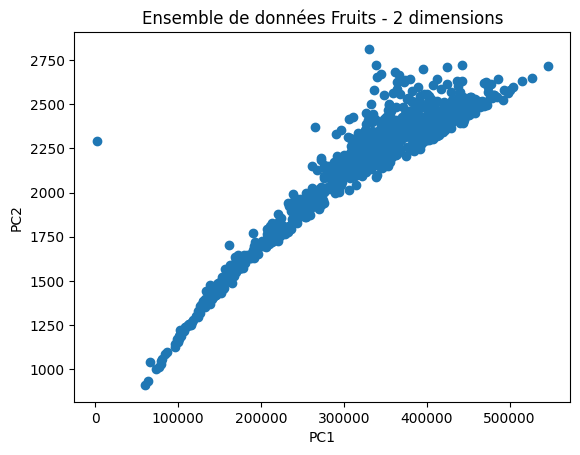

In [15]:
plt.scatter(Data[:, 0], Data[:, 1],marker='o')
plt.title("Ensemble de données Fruits - 2 dimensions")
plt.xlabel("PC1")
plt.ylabel("PC2");
plt.show()

**2) Méthode K-means (7 clusters)**

**a) Sans prétraitements**

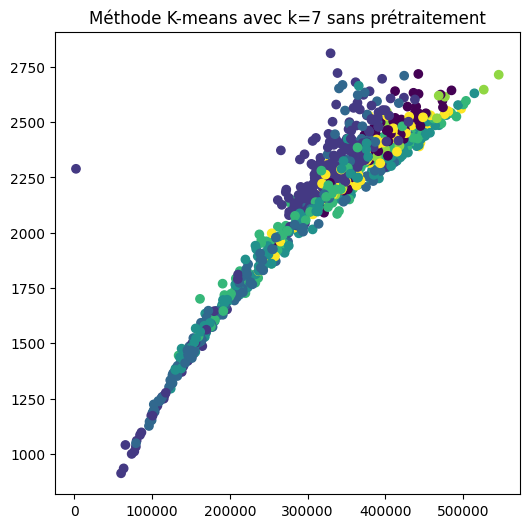

In [16]:
# Application de la méthode K-means
y_pred_kmeans_brut = KMeans(n_clusters=7, init='random', random_state=20).fit_predict(Data)

# Affichage des clusters
plt.figure(figsize=(6, 6))
plt.scatter(Data[:, 0], Data[:, 1], c=y_pred_kmeans_brut)
plt.title("Méthode K-means avec k=7 sans prétraitement")
plt.show()

/tmp/ipykernel_257148/2480194987.py:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  number_labels[i] = reference_labels[y_pred[i]]


Score de performance : 55.790645879732736 %
[[  0  21  27   0  17   0   0]
 [  0  37  49   0  10   2   0]
 [  0  15 146   0   0  43   0]
 [  0  14  52   0   5   1   0]
 [  0  19   2   0 145   0   0]
 [  0   0  26   0   0 173   0]
 [  0  26  57   0   9   2   0]]


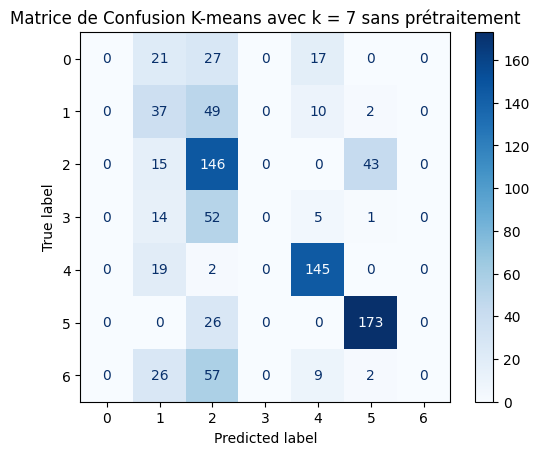

In [17]:
y_correspondant_kmeans_brut = correspondance(y_pred_kmeans_brut, integer_labels)
print('Score de performance :',(accuracy_score(y_correspondant_kmeans_brut, integer_labels)*100), '%')
matrice_confusion_kmeans_brut = confusion_matrix(integer_labels, y_correspondant_kmeans_brut)
print(matrice_confusion_kmeans_brut)

labels = np.unique(integer_labels)
display = ConfusionMatrixDisplay(confusion_matrix=matrice_confusion_kmeans_brut, display_labels=labels)
display.plot(cmap=plt.cm.Blues)
plt.title("Matrice de Confusion K-means avec k = 7 sans prétraitement")
plt.show()

**b) Avec prétraitements**

In [18]:
#Prétraitements
scaler = preprocessing.StandardScaler().fit(Data)
scaled = scaler.transform(Data)
min_max_scaler = preprocessing.MinMaxScaler().fit(Data)
scaled_min_max = min_max_scaler.transform(Data)
abs_scaler = preprocessing.MaxAbsScaler().fit(Data)
scaled_abs = abs_scaler.transform(Data)

In [19]:
# Application de la méthode K-means avec les trois prétraitements
y_pred_kmeans_stand = KMeans(n_clusters=7, init='random', random_state=20).fit_predict(scaled)
y_pred_kmeans_minmax = KMeans(n_clusters=7, init='random', random_state=20).fit_predict(scaled_min_max)
y_pred_kmeans_abs = KMeans(n_clusters=7, init='random', random_state=20).fit_predict(scaled_abs)


/tmp/ipykernel_257148/2480194987.py:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  number_labels[i] = reference_labels[y_pred[i]]


Score de performance (prétraitement standard scaler) : 75.27839643652561 %


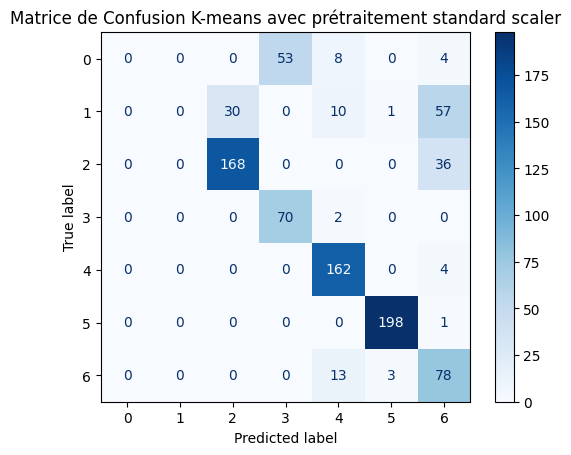

/tmp/ipykernel_257148/2480194987.py:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  number_labels[i] = reference_labels[y_pred[i]]


Score de performance (prétraitement minmax scaler) : 81.06904231625836 %


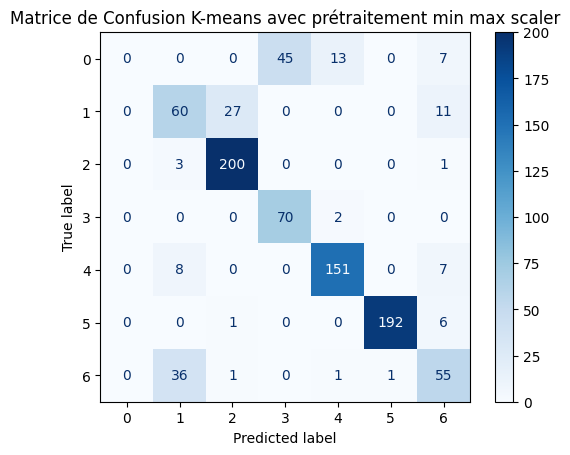

[[  0   0   0  45  13   0   7]
 [  0  60  27   0   0   0  11]
 [  0   3 200   0   0   0   1]
 [  0   0   0  70   2   0   0]
 [  0   8   0   0 151   0   7]
 [  0   0   1   0   0 192   6]
 [  0  36   1   0   1   1  55]]
Score de performance (prétraitement max abs scaler) : 74.05345211581292 %


/tmp/ipykernel_257148/2480194987.py:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  number_labels[i] = reference_labels[y_pred[i]]


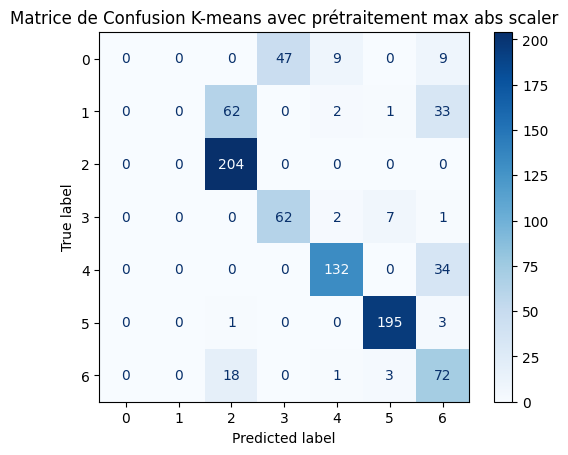

In [20]:
y_correspondant_kmeans_stand= correspondance(y_pred_kmeans_stand, integer_labels)
print('Score de performance (prétraitement standard scaler) :',(accuracy_score(y_correspondant_kmeans_stand, integer_labels)*100), '%')
matrice_confusion_kmeans_stand = confusion_matrix(integer_labels, y_correspondant_kmeans_stand)
labels = np.unique(integer_labels)
display = ConfusionMatrixDisplay(confusion_matrix=matrice_confusion_kmeans_stand, display_labels=labels)
display.plot(cmap=plt.cm.Blues)
plt.title("Matrice de Confusion K-means avec prétraitement standard scaler")
plt.show()

y_correspondant_kmeans_minmax = correspondance(y_pred_kmeans_minmax, integer_labels)
print('Score de performance (prétraitement minmax scaler) :',(accuracy_score(y_correspondant_kmeans_minmax, integer_labels)*100), '%')
matrice_confusion_kmeans_minmax = confusion_matrix(integer_labels, y_correspondant_kmeans_minmax)
labels = np.unique(integer_labels)
display = ConfusionMatrixDisplay(confusion_matrix=matrice_confusion_kmeans_minmax, display_labels=labels)
display.plot(cmap=plt.cm.Blues)
plt.title("Matrice de Confusion K-means avec prétraitement min max scaler")
plt.show()
print(matrice_confusion_kmeans_minmax)

y_correspondant_kmeans_abs = correspondance(y_pred_kmeans_abs, integer_labels)
print('Score de performance (prétraitement max abs scaler) :',(accuracy_score(y_correspondant_kmeans_abs, integer_labels)*100), '%')
matrice_confusion_kmeans_abs = confusion_matrix(integer_labels, y_correspondant_kmeans_abs)
labels = np.unique(integer_labels)
display = ConfusionMatrixDisplay(confusion_matrix=matrice_confusion_kmeans_abs, display_labels=labels)
display.plot(cmap=plt.cm.Blues)
plt.title("Matrice de Confusion K-means avec prétraitement max abs scaler")
plt.show()

**3) Méthode Gaussian Mixture**

**a) Sans prétraitements**

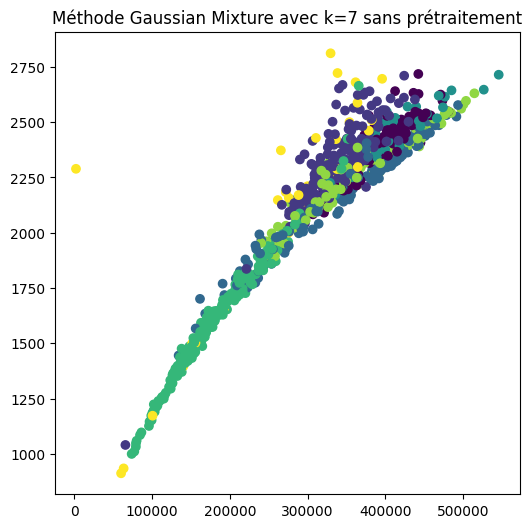

In [21]:
# Application de la méthode Gaussian Mixture
y_pred_gm_brut = GaussianMixture(n_components=7, covariance_type='full', random_state=20).fit_predict(Data)

# Affichage des clusters
plt.figure(figsize=(6, 6))
plt.scatter(Data[:, 0], Data[:, 1], c=y_pred_gm_brut)
plt.title("Méthode Gaussian Mixture avec k=7 sans prétraitement")
plt.show()

/tmp/ipykernel_257148/2480194987.py:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  number_labels[i] = reference_labels[y_pred[i]]


Score de performance : 68.48552338530067 %


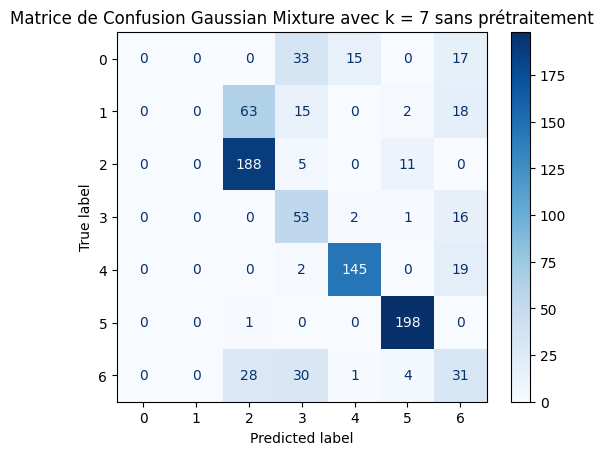

In [22]:
y_correspondant_gm_brut = correspondance(y_pred_gm_brut,integer_labels)
print('Score de performance :',(accuracy_score(y_correspondant_gm_brut, integer_labels)*100), '%')
matrice_confusion_gm_brut = confusion_matrix(integer_labels, y_correspondant_gm_brut)
labels = np.unique(integer_labels)
display = ConfusionMatrixDisplay(confusion_matrix=matrice_confusion_gm_brut, display_labels=labels)
display.plot(cmap=plt.cm.Blues)
plt.title("Matrice de Confusion Gaussian Mixture avec k = 7 sans prétraitement")
plt.show()

**b) Avec prétraitements**

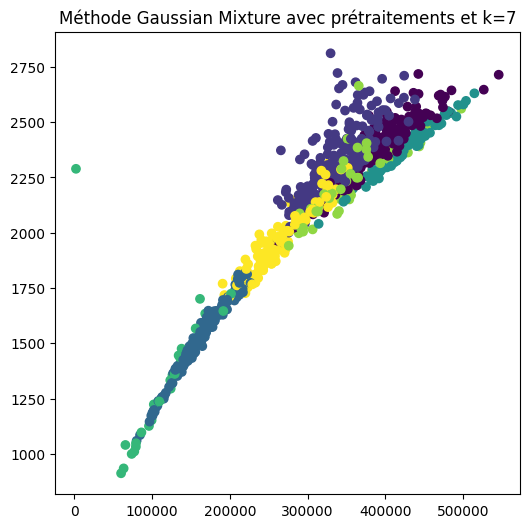

In [23]:
# Application de la méthode Gaussian Mixture
y_pred_gm_pre = GaussianMixture(n_components=7, covariance_type='full', random_state=20).fit_predict(scaled_min_max)

# Affichage des clusters
plt.figure(figsize=(6, 6))
plt.scatter(Data[:, 0], Data[:, 1], c=y_pred_gm_pre)
plt.title("Méthode Gaussian Mixture avec prétraitements et k=7")
plt.show()

/tmp/ipykernel_257148/2480194987.py:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  number_labels[i] = reference_labels[y_pred[i]]


Score de performance : 79.62138084632517 %


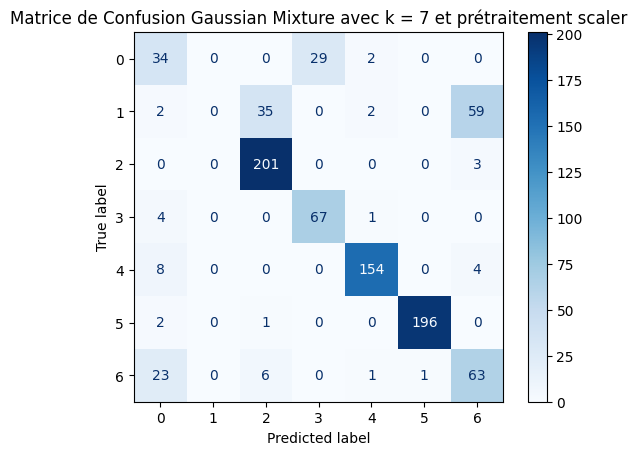

In [24]:
y_correspondant_gm_pre = correspondance(y_pred_gm_pre,integer_labels)
print('Score de performance :',(accuracy_score(y_correspondant_gm_pre, integer_labels)*100), '%')
matrice_confusion_gm_pre = confusion_matrix(integer_labels, y_correspondant_gm_pre)
labels = np.unique(integer_labels)
display = ConfusionMatrixDisplay(confusion_matrix=matrice_confusion_gm_pre, display_labels=labels)
display.plot(cmap=plt.cm.Blues)
plt.title("Matrice de Confusion Gaussian Mixture avec k = 7 et prétraitement scaler")
plt.show()

# Partie II : classification des phonèmes avec prétraitement


## Méthode supervisée avec réduction de dimension par ACP sur l'ensemble d'apprentissage
Réaliser une ACP sur l'ensemble d'apprentissage pour réduire la dimension, visualiser les données
puis projeter les données de l'ensemble de test dans la base de l'ACP.

Indiquer quelle est la méthode supervisée de votre choix et calculer la matrice de confusion associée (confusion_matrix) et le score de performance (accuracy_score)




In [25]:
from sklearn.decomposition import PCA

n_components=2
pca = PCA(n_components)
principalComponents = pca.fit_transform(Data)
principalComponents_scaled = pca.fit_transform(scaled_data)

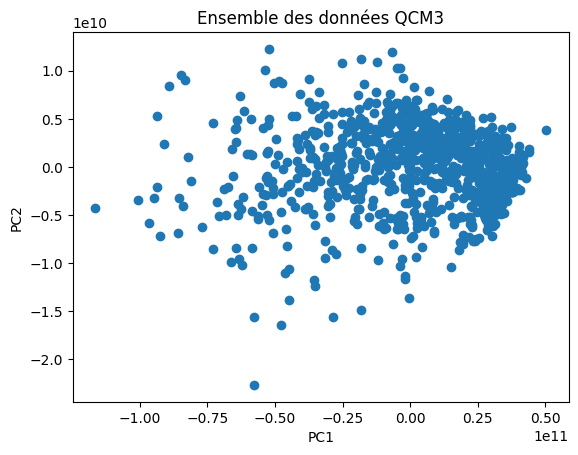

In [26]:
# Affichage des points
plt.scatter(principalComponents[:, 0], principalComponents[:, 1])
plt.title("Ensemble des données QCM3")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

In [27]:
X_train, X_test, y_train, y_test = train_test_split(principalComponents, integer_labels, random_state=0,test_size=0.2)
X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(principalComponents_scaled, integer_labels, random_state=0,test_size=0.2)

print('Dimension Base d apprentissage :', X_train.shape)
print('Dimension Base de test :', X_test.shape)

Dimension Base d apprentissage : (718, 2)
Dimension Base de test : (180, 2)


**1) Bayes**

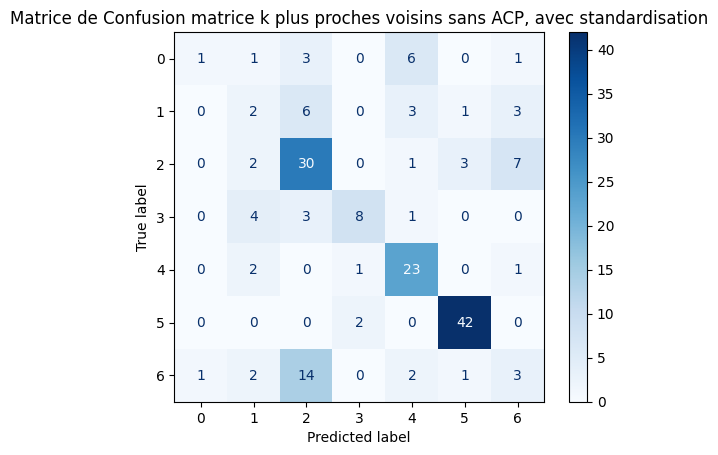

0.6055555555555555

In [28]:
clf = GaussianNB()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
labels = np.unique(integer_labels)
display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
display.plot(cmap=plt.cm.Blues)
plt.title("Matrice de Confusion matrice bayésienne sans prétraitement")
plt.title("Matrice de Confusion matrice k plus proches voisins sans ACP, avec standardisation")

plt.show()

accuracy(cm)

**Scaled**

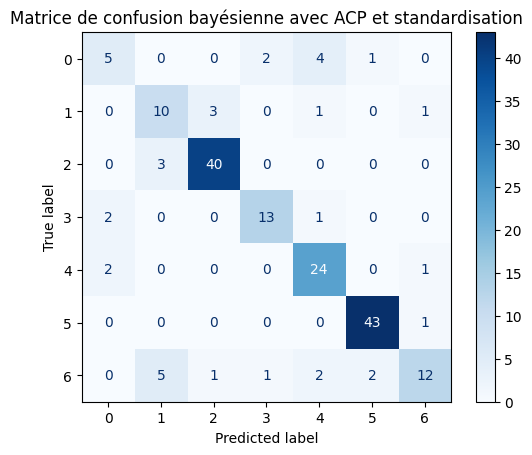

0.8166666666666667

In [29]:
clf.fit(X_train_scaled, y_train_scaled)
y_pred_Bayes = clf.predict(X_test_scaled)
cm = confusion_matrix(y_test_scaled, y_pred_Bayes, labels=clf.classes_)
labels = np.unique(integer_labels)
display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
display.plot(cmap=plt.cm.Blues)
plt.title("Matrice de confusion bayésienne avec ACP et standardisation")

plt.show()
accuracy(cm)

**2) Nearest Neighbors**

In [30]:
_accuracy = []
for k in range(1, len(X_train)):
    neigh = KNeighborsClassifier(n_neighbors=k)
    neigh.fit(X_train, y_train)
    y_pred = neigh.predict(X_test)
    _accuracy.append(np.sum(np.diagonal(confusion_matrix(y_test, y_pred))))


In [31]:
best_n_neighbors = np.argmax(np.array(_accuracy))

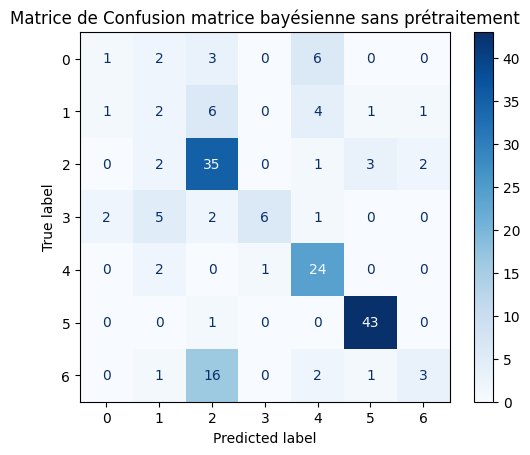

0.6333333333333333

In [32]:
neigh = KNeighborsClassifier(n_neighbors=best_n_neighbors+1)
neigh.fit(X_train, y_train)
y_pred = neigh.predict(X_test)
cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
labels = np.unique(integer_labels)
display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
display.plot(cmap=plt.cm.Blues)
plt.title("Matrice de Confusion matrice bayésienne sans prétraitement")
plt.show()
accuracy(cm)

**Scaled**

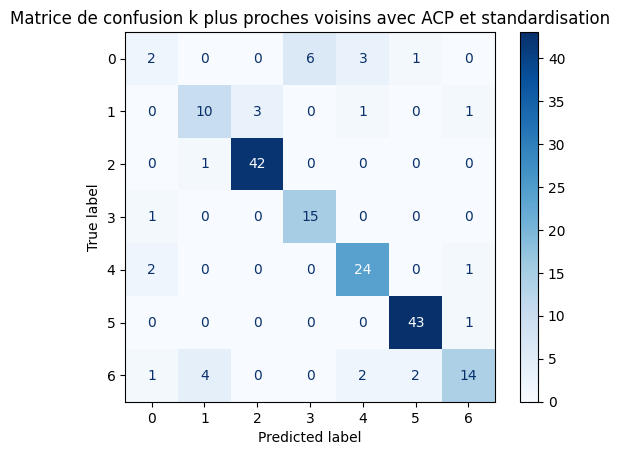

0.8333333333333334

In [33]:
_accuracy = []
for k in range(1, len(X_train_scaled)):
    neigh = KNeighborsClassifier(n_neighbors=k)
    neigh.fit(X_train_scaled, y_train_scaled)
    y_pred_neigh = neigh.predict(X_test_scaled)
    _accuracy.append(np.sum(np.diagonal(confusion_matrix(y_test, y_pred_neigh))))
best_n_neighbors = np.argmax(np.array(_accuracy))
neigh = KNeighborsClassifier(n_neighbors=best_n_neighbors + 1)
neigh.fit(X_train_scaled, y_train_scaled)
y_pred_neigh = neigh.predict(X_test_scaled)
cm = confusion_matrix(y_test_scaled, y_pred_neigh, labels=clf.classes_)
labels = np.unique(integer_labels)
display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
display.plot(cmap=plt.cm.Blues)
plt.title("Matrice de confusion k plus proches voisins avec ACP et standardisation")
plt.show()
accuracy(cm)

## Méthode non supervisée avec réduction de dimension par ACP sur l'ensemble des données

Réaliser une ACP sur l'ensemble des données et indiquer quelle est la méthode supervisée de votre choix et calculer la matrice de confusion associée (confusion_matrix) et le score de performance (accuracy_score)

**1) Réductions de dimensions par ACP**

  **a) 2 dimensions**

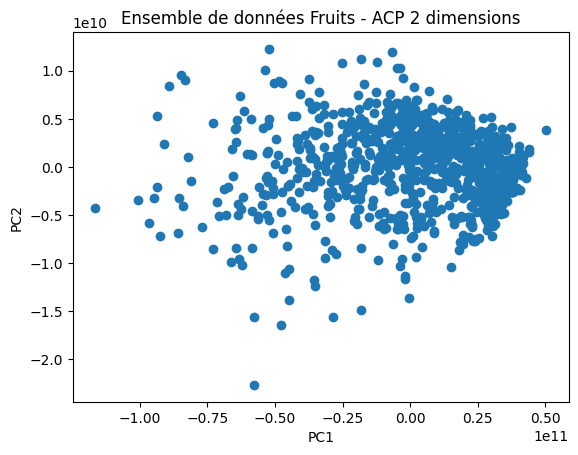

In [34]:
# Réduction de dimensions par ACP
n_components=2
pca2D = PCA(n_components)
principalComponents2D = pca2D.fit_transform(Data)


# affichage des points
plt.scatter(principalComponents2D[:, 0], principalComponents2D[:, 1],marker='o')
plt.title("Ensemble de données Fruits - ACP 2 dimensions")
plt.xlabel("PC1")
plt.ylabel("PC2");
plt.show()

  **b) 3 dimensions**

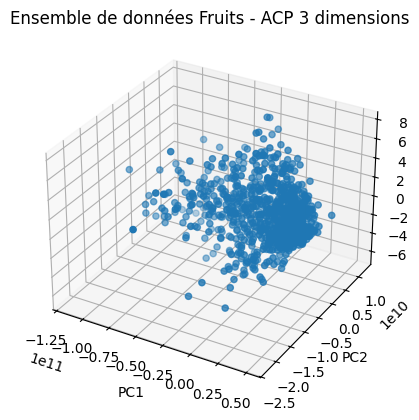

In [35]:
# Réduction de dimensions par ACP
n_components=3
pca3D = PCA(n_components)
principalComponents3D = pca3D.fit_transform(Data)


# affichage des points
ax = plt.axes(projection ="3d")
ax.scatter3D(principalComponents3D[:, 0], principalComponents3D[:, 1], principalComponents3D[:, 2],marker='o')
plt.title("Ensemble de données Fruits - ACP 3 dimensions")
plt.xlabel("PC1")
plt.ylabel("PC2");
plt.show()

**2) Méthode K-means (7 clusters)**

**a) Avec ACP 2 dimensions**

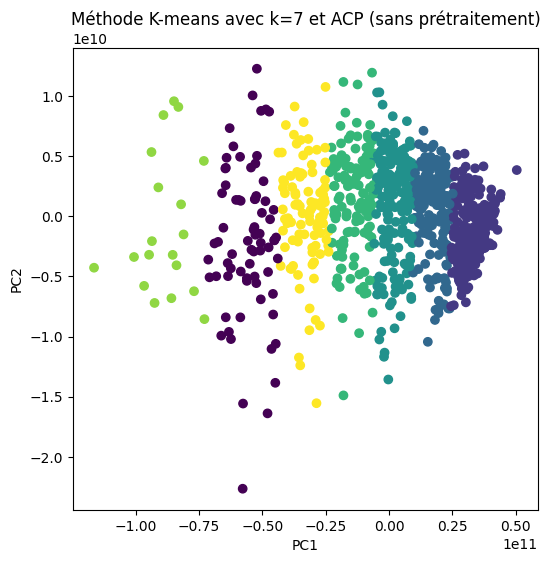

In [36]:
# Application de la méthode K-means
y_pred_kmeans2D = KMeans(n_clusters=7, init='random', random_state=20).fit_predict(principalComponents2D)

# Affichage des clusters
plt.figure(figsize=(6, 6))
plt.scatter(principalComponents2D[:, 0], principalComponents2D[:, 1], c=y_pred_kmeans2D)
plt.title("Méthode K-means avec k=7 et ACP (sans prétraitement)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

/tmp/ipykernel_257148/2480194987.py:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  number_labels[i] = reference_labels[y_pred[i]]


Score de performance : 56.013363028953236 %


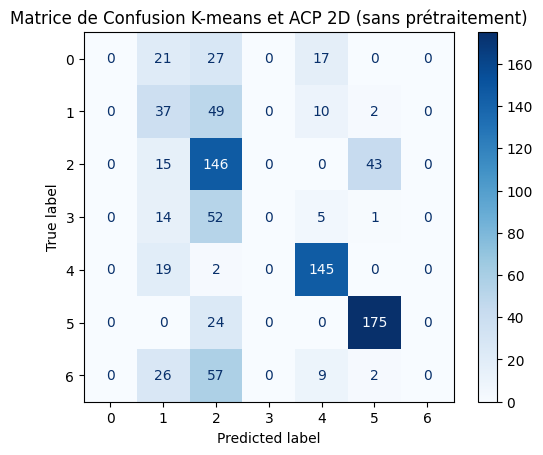

In [37]:
#Correspondance entre les clusters trouvés et les labels
y_correspondants_kmeans2D = correspondance(y_pred_kmeans2D, integer_labels)
print('Score de performance :',(accuracy_score(y_correspondants_kmeans2D, integer_labels))*100, '%')
matrice_confusion_kmeans2D = confusion_matrix(integer_labels, y_correspondants_kmeans2D)
labels = np.unique(integer_labels)
display = ConfusionMatrixDisplay(confusion_matrix=matrice_confusion_kmeans2D, display_labels=labels)
display.plot(cmap=plt.cm.Blues)
plt.title("Matrice de Confusion K-means et ACP 2D (sans prétraitement)")
plt.show()

**b) Avec ACP 3 dimensions**

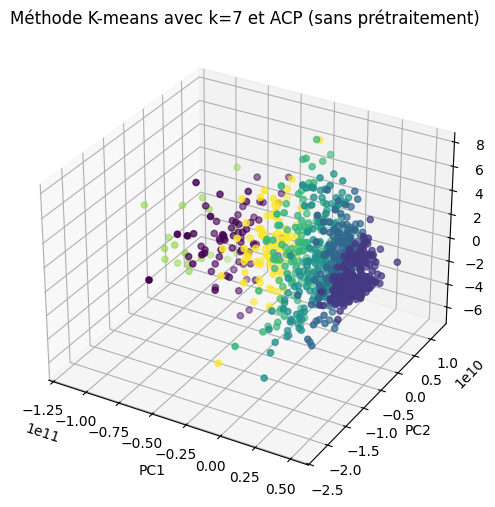

In [38]:
# Application de la méthode K-means
y_pred_kmeans3D = KMeans(n_clusters=7, init='random', random_state=20).fit_predict(principalComponents3D)

# Affichage des clusters
plt.figure(figsize=(6, 6))
ax = plt.axes(projection ="3d")
ax.scatter3D(principalComponents3D[:, 0], principalComponents3D[:, 1], principalComponents3D[:, 2], c=y_pred_kmeans3D)
plt.title("Méthode K-means avec k=7 et ACP (sans prétraitement)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

/tmp/ipykernel_257148/2480194987.py:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  number_labels[i] = reference_labels[y_pred[i]]


Score de performance : 56.013363028953236 %


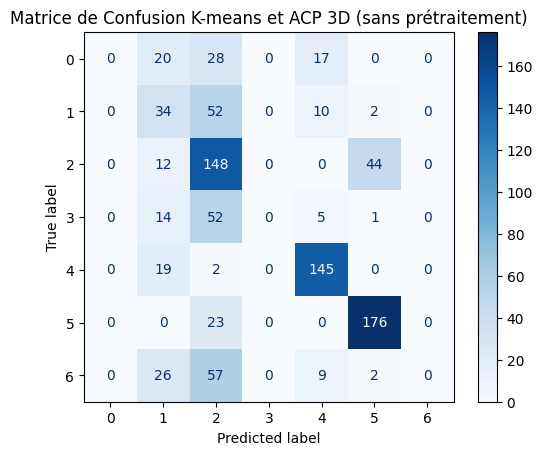

In [39]:
#Correspondance entre les clusters trouvés et les labels
y_correspondants_kmeans3D = correspondance(y_pred_kmeans3D, integer_labels)
print('Score de performance :',(accuracy_score(y_correspondants_kmeans3D, integer_labels))*100, '%')
matrice_confusion_kmeans3D = confusion_matrix(integer_labels, y_correspondants_kmeans3D)
labels = np.unique(integer_labels)
display = ConfusionMatrixDisplay(confusion_matrix=matrice_confusion_kmeans3D, display_labels=labels)
display.plot(cmap=plt.cm.Blues)
plt.title("Matrice de Confusion K-means et ACP 3D (sans prétraitement)")
plt.show()

**3) Méthode Gaussian Mixture (7 clusters)**

**a) Avec ACP 2 dimensions**

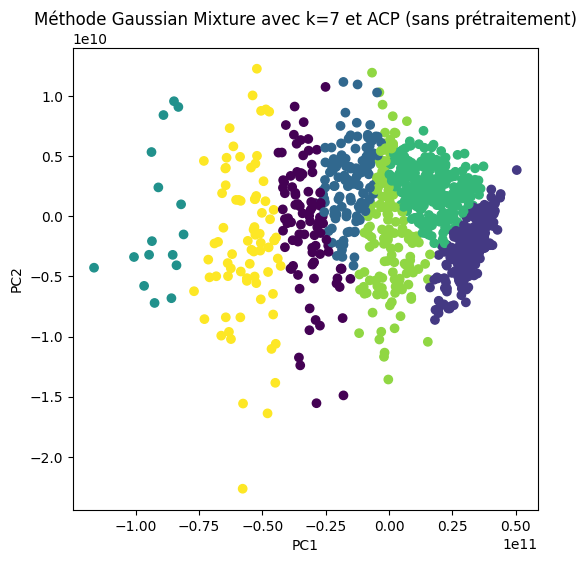

In [40]:
# Application de la méthode AffinityPropagation
y_pred_gm2D = GaussianMixture(n_components=7, covariance_type='full', random_state=20).fit_predict(principalComponents2D)

# Affichage des clusters
plt.figure(figsize=(6, 6))
plt.scatter(principalComponents2D[:, 0], principalComponents2D[:, 1], c=y_pred_gm2D)
plt.title("Méthode Gaussian Mixture avec k=7 et ACP (sans prétraitement)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

/tmp/ipykernel_257148/2480194987.py:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  number_labels[i] = reference_labels[y_pred[i]]


Score de performance : 61.80400890868597 %


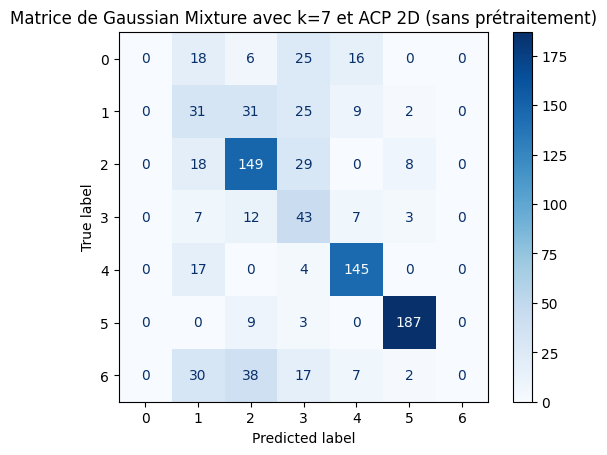

In [41]:
#Correspondance entre les clusters trouvés et les labels
y_correspondants_gm2D = correspondance(y_pred_gm2D,integer_labels)
print('Score de performance :',(accuracy_score(y_correspondants_gm2D, integer_labels))*100, '%')
matrice_confusion_kmeans2D = confusion_matrix(integer_labels, y_correspondants_gm2D)
labels = np.unique(integer_labels)
display = ConfusionMatrixDisplay(confusion_matrix=matrice_confusion_kmeans2D, display_labels=labels)
display.plot(cmap=plt.cm.Blues)
plt.title("Matrice de Gaussian Mixture avec k=7 et ACP 2D (sans prétraitement)")
plt.show()

**b) Avec ACP 3 dimensions**

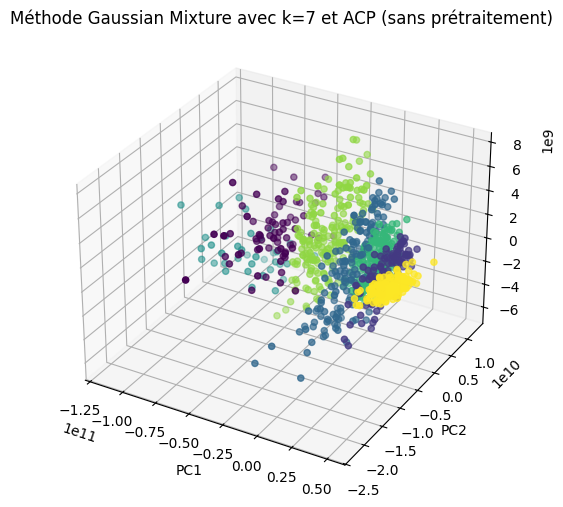

In [42]:
# Application de la méthode AffinityPropagation
y_pred_gm3D = GaussianMixture(n_components=7, covariance_type='full', random_state=20).fit_predict(principalComponents3D)

# Affichage des clusters
plt.figure(figsize=(6, 6))
ax = plt.axes(projection ="3d")
ax.scatter3D(principalComponents3D[:, 0], principalComponents3D[:, 1], principalComponents3D[:, 2], c=y_pred_gm3D)
plt.title("Méthode Gaussian Mixture avec k=7 et ACP (sans prétraitement)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

/tmp/ipykernel_257148/2480194987.py:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  number_labels[i] = reference_labels[y_pred[i]]


Score de performance : 61.581291759465486 %


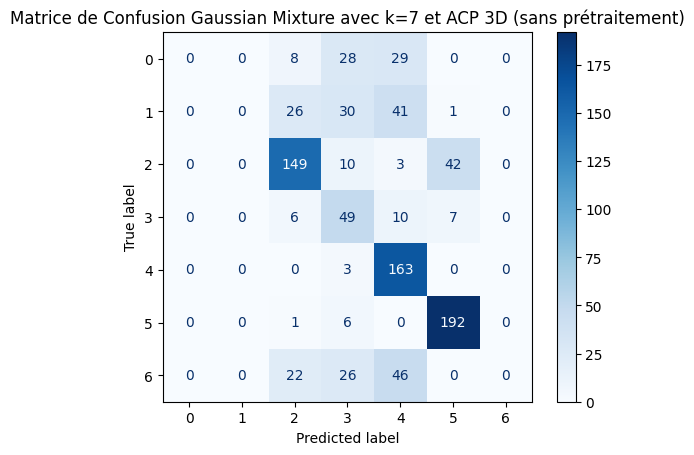

In [43]:
#Correspondance entre les clusters trouvés et les labels
y_correspondants_gm3D = correspondance(y_pred_gm3D,integer_labels)
print('Score de performance :',(accuracy_score(y_correspondants_gm3D, integer_labels))*100, '%')
matrice_confusion_gm3D = confusion_matrix(integer_labels, y_correspondants_gm3D)
labels = np.unique(integer_labels)
display = ConfusionMatrixDisplay(confusion_matrix=matrice_confusion_gm3D, display_labels=labels)
display.plot(cmap=plt.cm.Blues)
plt.title("Matrice de Confusion Gaussian Mixture avec k=7 et ACP 3D (sans prétraitement)")
plt.show()

**4) ACP après prétraitements scaler**

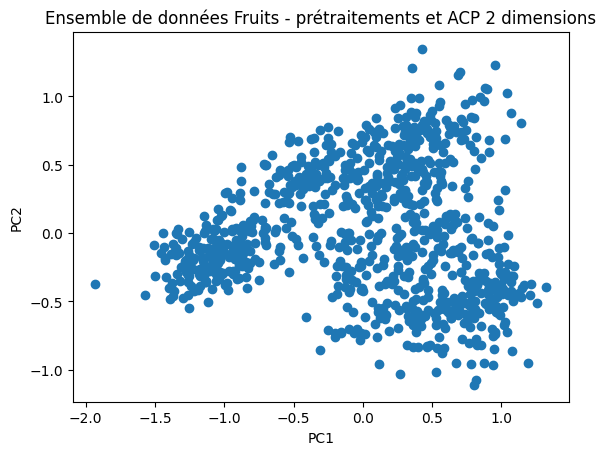

In [44]:
# Réduction de dimensions par ACP 2D
n_components=2
pca2D_pre = PCA(n_components)
principalComponents2D_pre = pca2D_pre.fit_transform(scaled_min_max)


# affichage des points
plt.scatter(principalComponents2D_pre[:, 0], principalComponents2D_pre[:, 1],marker='o')
plt.title("Ensemble de données Fruits - prétraitements et ACP 2 dimensions")
plt.xlabel("PC1")
plt.ylabel("PC2");
plt.show()

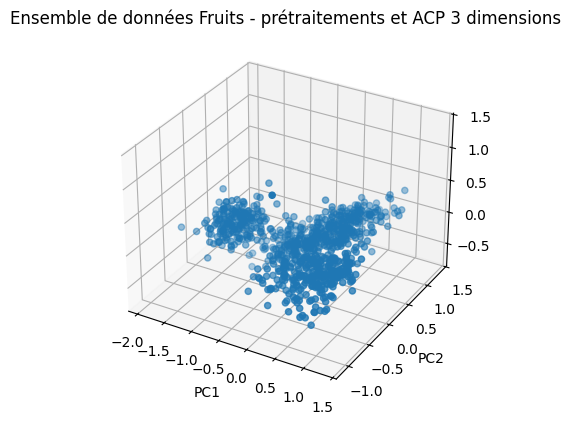

In [45]:
# Réduction de dimensions par ACP 3D
n_components=3
pca3D_pre = PCA(n_components)
principalComponents3D_pre = pca3D_pre.fit_transform(scaled_min_max)


# affichage des points
ax = plt.axes(projection ="3d")
ax.scatter3D(principalComponents3D_pre[:, 0], principalComponents3D_pre[:, 1], principalComponents3D_pre[:, 2],marker='o')
plt.title("Ensemble de données Fruits - prétraitements et ACP 3 dimensions")
plt.xlabel("PC1")
plt.ylabel("PC2");
plt.show()

**5) K-means**

**a) Avec ACP 2 dimensions et prétraitements**

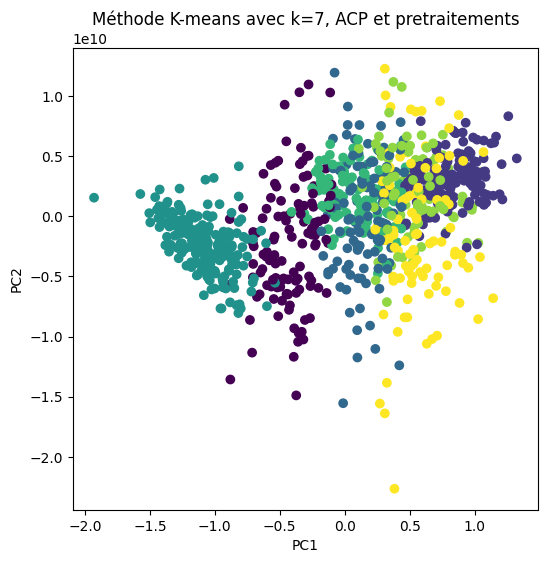

In [46]:
# Application de la méthode K-means
y_pred_kmeans2D_pre = KMeans(n_clusters=7, init='random', random_state=20).fit_predict(principalComponents2D_pre)

# Affichage des clusters
plt.figure(figsize=(6, 6))
plt.scatter(principalComponents2D_pre[:, 0], principalComponents2D[:, 1], c=y_pred_kmeans2D_pre)
plt.title("Méthode K-means avec k=7, ACP et pretraitements")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

/tmp/ipykernel_257148/2480194987.py:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  number_labels[i] = reference_labels[y_pred[i]]


Score de performance : 73.4966592427617 %


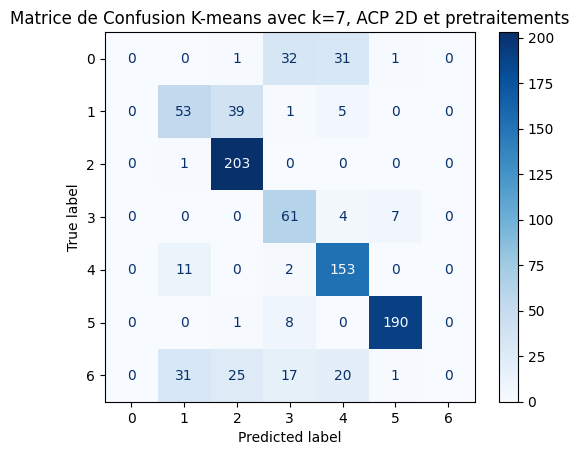

In [47]:
#Correspondance entre les clusters trouvés et les labels
y_correspondants_kmeans2D_pre = correspondance(y_pred_kmeans2D_pre, integer_labels)
print('Score de performance :',(accuracy_score(y_correspondants_kmeans2D_pre, integer_labels))*100, '%')
matrice_confusion_kmeans2D_pre = confusion_matrix(integer_labels, y_correspondants_kmeans2D_pre)
labels = np.unique(integer_labels)
display = ConfusionMatrixDisplay(confusion_matrix=matrice_confusion_kmeans2D_pre, display_labels=labels)
display.plot(cmap=plt.cm.Blues)
plt.title("Matrice de Confusion K-means avec k=7, ACP 2D et pretraitements")
plt.show()

**b) Avec ACP 3 dimensions et prétraitements**

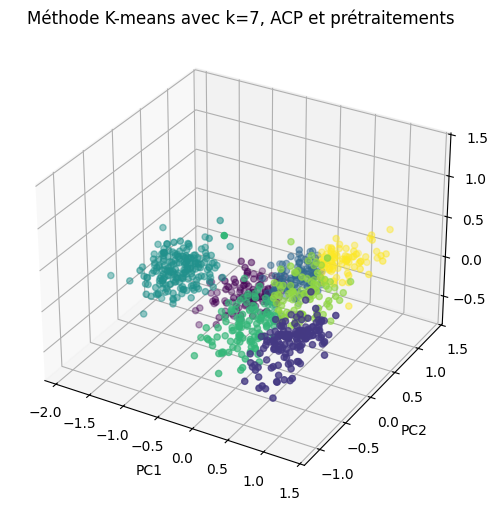

In [48]:
# Application de la méthode K-means
y_pred_kmeans3D_pre = KMeans(n_clusters=7, init='random', random_state=20).fit_predict(principalComponents3D_pre)

# Affichage des clusters
plt.figure(figsize=(6, 6))
ax = plt.axes(projection ="3d")
ax.scatter3D(principalComponents3D_pre[:, 0], principalComponents3D_pre[:, 1], principalComponents3D_pre[:, 2], c=y_pred_kmeans3D_pre)
plt.title("Méthode K-means avec k=7, ACP et prétraitements")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

/tmp/ipykernel_257148/2480194987.py:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  number_labels[i] = reference_labels[y_pred[i]]


Score de performance : 75.50111358574611 %


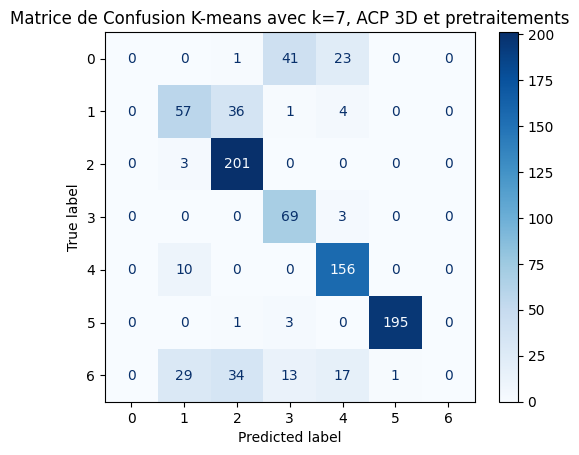

In [49]:
#Correspondance entre les clusters trouvés et les labels
y_correspondants_kmeans_3D_pre = correspondance(y_pred_kmeans3D_pre, integer_labels)
print('Score de performance :',(accuracy_score(y_correspondants_kmeans_3D_pre, integer_labels))*100, '%')
matrice_confusion_kmeans_3D_pre = confusion_matrix(integer_labels, y_correspondants_kmeans_3D_pre)
labels = np.unique(integer_labels)
display = ConfusionMatrixDisplay(confusion_matrix=matrice_confusion_kmeans_3D_pre, display_labels=labels)
display.plot(cmap=plt.cm.Blues)
plt.title("Matrice de Confusion K-means avec k=7, ACP 3D et pretraitements")
plt.show()

**6) Gaussian Mixture**

**a) Avec ACP 2 dimensions et prétraitements**

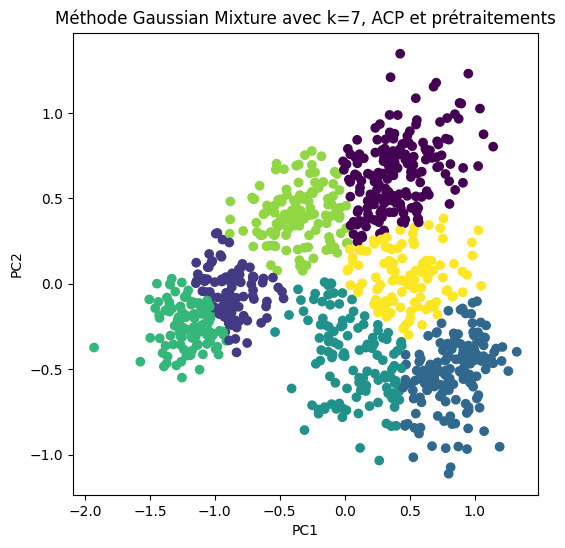

In [50]:
y_pred_gm2D_pre = GaussianMixture(n_components=7, covariance_type='full', random_state=20).fit_predict(principalComponents2D_pre)

# Affichage des clusters
plt.figure(figsize=(6, 6))
plt.scatter(principalComponents2D_pre[:, 0], principalComponents2D_pre[:, 1], c=y_pred_gm2D_pre)
plt.title("Méthode Gaussian Mixture avec k=7, ACP et prétraitements")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

/tmp/ipykernel_257148/2480194987.py:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  number_labels[i] = reference_labels[y_pred[i]]


Score de performance : 73.4966592427617 %


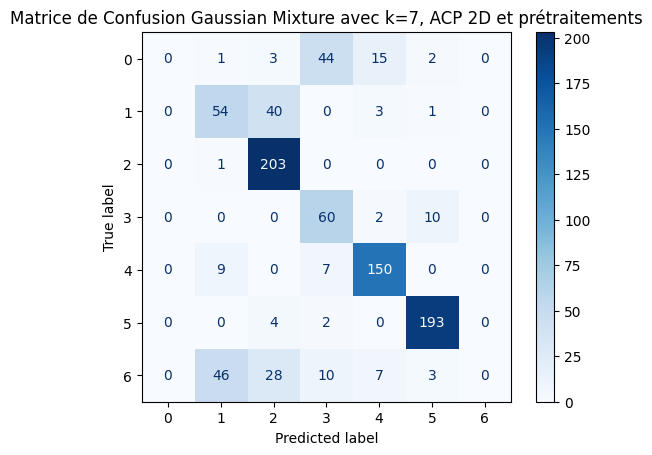

In [51]:
#Correspondance entre les clusters trouvés et les labels
y_correspondants_gm2D_pre = correspondance(y_pred_gm2D_pre, integer_labels)
print('Score de performance :',(accuracy_score(y_correspondants_gm2D_pre, integer_labels))*100, '%')
matrice_confusion_gm2D_pre = confusion_matrix(integer_labels, y_correspondants_gm2D_pre)
labels = np.unique(integer_labels)
display = ConfusionMatrixDisplay(confusion_matrix=matrice_confusion_gm2D_pre, display_labels=labels)
display.plot(cmap=plt.cm.Blues)
plt.title("Matrice de Confusion Gaussian Mixture avec k=7, ACP 2D et prétraitements")
plt.show()

**b) Avec ACP 3 dimensions et prétraitements**

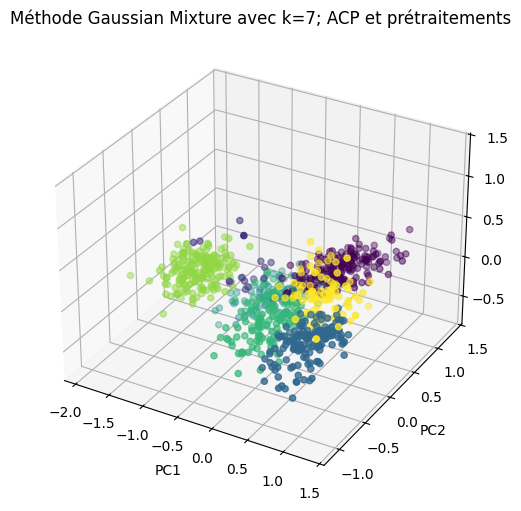

In [52]:
y_pred_gm3D_pre = GaussianMixture(n_components=7, covariance_type='full', random_state=20).fit_predict(principalComponents3D_pre)

# Affichage des clusters
plt.figure(figsize=(6, 6))
ax = plt.axes(projection ="3d")
ax.scatter3D(principalComponents3D_pre[:, 0], principalComponents3D_pre[:, 1], principalComponents3D_pre[:, 2], c=y_pred_gm3D_pre)
plt.title("Méthode Gaussian Mixture avec k=7; ACP et prétraitements")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

/tmp/ipykernel_257148/2480194987.py:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  number_labels[i] = reference_labels[y_pred[i]]


Score de performance : 73.83073496659243 %


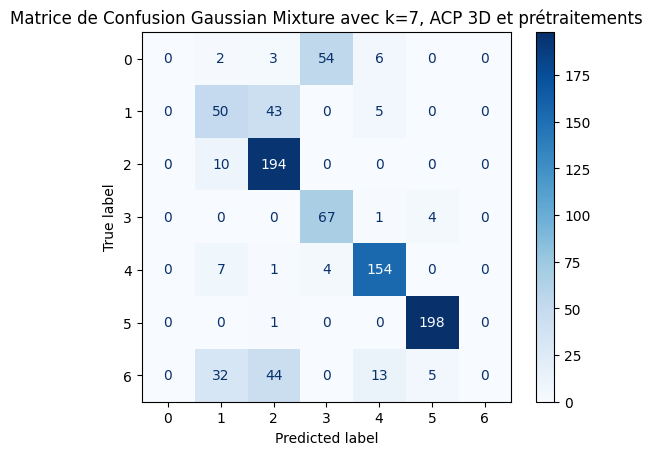

In [53]:
#Correspondance entre les clusters trouvés et les labels
y_correspondants_gm3D_pre = correspondance(y_pred_gm3D_pre, integer_labels)
print('Score de performance :',(accuracy_score(y_correspondants_gm3D_pre, integer_labels))*100, '%')
matrice_confusion_gm3D_pre = confusion_matrix(integer_labels, y_correspondants_gm3D_pre)
labels = np.unique(integer_labels)
display = ConfusionMatrixDisplay(confusion_matrix=matrice_confusion_gm3D_pre, display_labels=labels)
display.plot(cmap=plt.cm.Blues)
plt.title("Matrice de Confusion Gaussian Mixture avec k=7, ACP 3D et prétraitements")
plt.show()

In [54]:
#ANNEXE : recherche du meilleur parametre random_state avec la methode Kmeans avec pretraitement
import warnings
warnings.filterwarnings('ignore')

best_score = 0
best_random_state = None
best_confusion_matrix = None
best_y_pred = None

for random_state in range(100): #recherche de la valeur entre 0 et 99

    y_pred_iter = KMeans(n_clusters=7, init='random', random_state=random_state).fit_predict(scaled_min_max)
    y_correspondant_iter = correspondance(y_pred_iter, integer_labels)
    
    # Calcul du score de performance
    score = accuracy_score(y_correspondant_iter, integer_labels)
    
    # Mise à jour du meilleur score et des paramètres correspondants
    if score > best_score:
        best_score = score
        best_random_state = random_state
        best_confusion_matrix = confusion_matrix(integer_labels, y_correspondant_iter)
        best_y_pred = y_correspondant_iter


print(f'Best random_state Kmeans: {best_random_state}')
print(f'Score de performance (prétraitement minmax scaler) : {best_score * 100:.2f} %')

Best random_state Kmeans: 20
Score de performance (prétraitement minmax scaler) : 81.07 %


In [55]:
#ANNEXE : recherche du meilleur parametre random_state avec la methode Gaussian Mixture avec pretraitement
# Le code suivant mettant plus de 8 minutes à s'executer, il est preferable de laisser cette partie commentée
# best_score = 0
# best_random_state = None
# best_confusion_matrix = None
# best_y_pred = None

# for random_state in range(100): #recherche de la valeur entre 0 et 99

#     y_pred_iter = GaussianMixture(n_components=7, covariance_type='full', random_state=random_state).fit_predict(scaled_min_max)
#     y_correspondant_iter = correspondance(y_pred_iter, integer_labels)
    
#     # Calcul du score de performance
#     score = accuracy_score(y_correspondant_iter, integer_labels)
    
#     # Mise à jour du meilleur score et des paramètres correspondants
#     if score > best_score:
#         best_score = score
#         best_random_state = random_state
#         best_confusion_matrix = confusion_matrix(integer_labels, y_correspondant_iter)
#         best_y_pred = y_correspondant_iter


# print(f'Best random_state Gaussian Mixture: {best_random_state}')
# print(f'Score de performance (prétraitement minmax scaler) : {best_score * 100:.2f} %')

Best random_state Gaussian Mixture: 51
Score de performance (prétraitement minmax scaler) : 81.51 %
